## Conditional entropies evaluation
#### Test conditions: 
    a = 0.5
    b = 1/16.0
    A = 2.5
    omega = 2.0
    gamma = 0.1
    period = 2*np.pi/(1.0*omega)
    h = period/32 # time step
    
    new_data = position[::23]

In [5]:
import sys
sys.path.insert(0, '../../dcgram_v2')
import save_plot as sp
import numpy as np
sys.path.insert(0, '../../dcgram_v2/tests')
from pibic import *
import yaml
import matplotlib.pyplot as plt

In [ ]:
sp.save_plot(parameter='cond_entropies', name='duffing_equation', drange = range(2,6), krange = [3, 5, 7])

## Kolmogorov-Smirnov Tests

In [41]:
path = '../..'

def kolmogorov_test(beta = 0.1, D = 2, K = 3, \
                    subseq_len = 1000, subseq_rep = 1000, dataset = 'duffing_equation', L = 1391305):
    
    leg = '{:1.2f}'.format(beta).replace('.', '')
    with open(f'{path}/dcgram_files/{dataset}/original/original_len_{L}.yaml', 'r') as f:
        s = yaml.load(f)    
    with open(f'{path}/dcgram_files/{dataset}/results/machines/dcgram/dcgram_D{D}_K{K}.yaml', 'r') as f:
        m_test = yaml.load(f)
    with open(f'{path}/dcgram_files/{dataset}_{leg}/original/original_len_{L}.yaml', 'r') as f:
        s_test = yaml.load(f)
    
    occup_vector, std, avg = calc_mean_vector(m_test, s, subseq_len, rep = subseq_rep)
    occup_vector_anomaly, std, avg = calc_mean_vector(m_test, s_test, subseq_len, rep = subseq_rep)
    
    stat, p = ks_2samp(occup_vector, occup_vector_anomaly)
    return stat, p

def plot_graph(x=[], y=[], D=2, K=3, ylabel='p-value'):
    plt.plot(x, y)
    plt.title(f'D={D}, K={K}')
    plt.xlabel(r'$\beta$')
    plt.ylabel(ylabel)
    plt.savefig(f'{ylabel}_D{D}_K{K}.png')

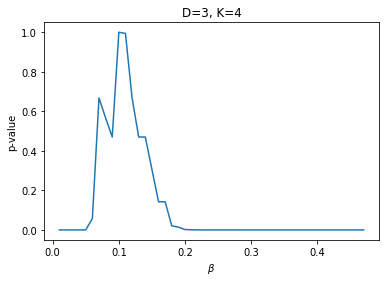

In [65]:
betas = np.arange(0.01, 0.48, 0.01)

p = []
stat = []

for D in [3]:
    K = 4
    
    for beta in betas:
        stval, pval = kolmogorov_test(beta = beta, D = 4, K = 3, subseq_len = 10000, subseq_rep = 1)
        p.append(pval)
        stat.append(stval)

    plot_graph(betas, p, D, K, ylabel='p-value')


In [58]:
dataset = 'duffing_equation'
leg = '010'
L = 1391305
D = 3
K = 3

with open(f'{path}/dcgram_files/{dataset}/original/original_len_{L}.yaml', 'r') as f:
    s = yaml.load(f)    
with open(f'{path}/dcgram_files/{dataset}/results/machines/dcgram/dcgram_D{D}_K{K}.yaml', 'r') as f:
    m_test = yaml.load(f)
with open(f'{path}/dcgram_files/{dataset}_{leg}/original/original_len_{L}.yaml', 'r') as f:
    s_test = yaml.load(f)

In [59]:
occup_vector, std, avg = calc_mean_vector(m_test, s, 1000, rep = 1000)

In [64]:
len(m_test.states)

34